In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import warnings
import os

import gfdl_utils.core as gu
import CM4Xutils
import cftime
import numpy as np
import pandas as pd
import xarray as xr
import xgcm
import xhistogram
import xwmt

import cmocean
import matplotlib.colors as colors
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import matplotlib.dates as mdates
plt.rcParams.update({'font.size': 11})

import doralite
sg = xr.open_dataset("/archive/Raphael.Dussin/datasets/OM4p125/mosaic_c192_om4p125_bedmachine_v20210310_hydrographyKDunne20210614_unpacked/ocean_hgrid.nc")
og = gu.open_static(doralite.dora_metadata("odiv-255")["pathPP"], "ocean_annual")

og = og.assign_coords({
    'geolon'  : xr.DataArray(sg['x'][1::2,1::2].data, dims=["yh", "xh"]),
    'geolat'  : xr.DataArray(sg['y'][1::2,1::2].data, dims=["yh", "xh"]),
    'geolon_u': xr.DataArray(sg['x'][1::2,0::2].data, dims=["yh", "xq"]),
    'geolat_u': xr.DataArray(sg['y'][1::2,0::2].data, dims=["yh", "xq"]),
    'geolon_v': xr.DataArray(sg['x'][0::2,1::2].data, dims=["yq", "xh"]),
    'geolat_v': xr.DataArray(sg['y'][0::2,1::2].data, dims=["yq", "xh"]),
    'geolon_c': xr.DataArray(sg['x'][0::2,0::2].data, dims=["yq", "xq"]),
    'geolat_c': xr.DataArray(sg['y'][0::2,0::2].data, dims=["yq", "xq"])
})

In [8]:
path = "../data/Wang2021_MITgcm_CFCs/data/"

In [9]:
from common import *

In [10]:
ds = xr.open_mfdataset(f"{path}CFCflux_Hist.nc").isel(Zd000001=0).rename({"SDIAG1":"fgcfc11"}) # mol/km2/s
ds = ds.assign_coords({"time": ds.T/sec_per_year_wang21 - 5900 + 1900}).swap_dims({"T":"time"}).roll(shifts={"X":-21}, roll_coords=True)
ds = ds.assign_coords(
    {"X": np.mod(ds.X.values + 300, 360) - 300}
)

grid = xr.open_dataset(f"{path}/grid.nc").roll(shifts={"X":-21}, roll_coords=True)
grid = grid.assign_coords(
    {"X": np.mod(grid.X.values + 300, 360) - 300}
)

In [15]:
inv_dict = {}

for model in models.keys():
    inv_path = f"../data/interim/transient_tracer_inventory_{model}-SSP585.nc"
    if os.path.exists(inv_path):
        print(f"Loading inert tracer inventories for {model} (forced historical + SSP5-8.5)")
        inv_dict[model] = xr.open_dataset(inv_path)

print(f"Loading inert tracer inventories for CM4Xp125 (piControl)")
inv_dict["CM4Xp125-piControl"] = xr.open_dataset("../data/interim/transient_tracer_inventory_CM4Xp125-piControl.nc")
# align times with historical + SSP5-8.5
inv_dict["CM4Xp125-piControl"] = inv_dict["CM4Xp125-piControl"].assign_coords(
    {"time": inv_dict["CM4Xp125"].time[0:inv_dict["CM4Xp125-piControl"].time.size]}
)

Loading inert tracer inventories for CM4Xp25 (forced historical + SSP5-8.5)
Loading inert tracer inventories for CM4Xp125 (forced historical + SSP5-8.5)
Loading inert tracer inventories for CM4Xp125 (piControl)


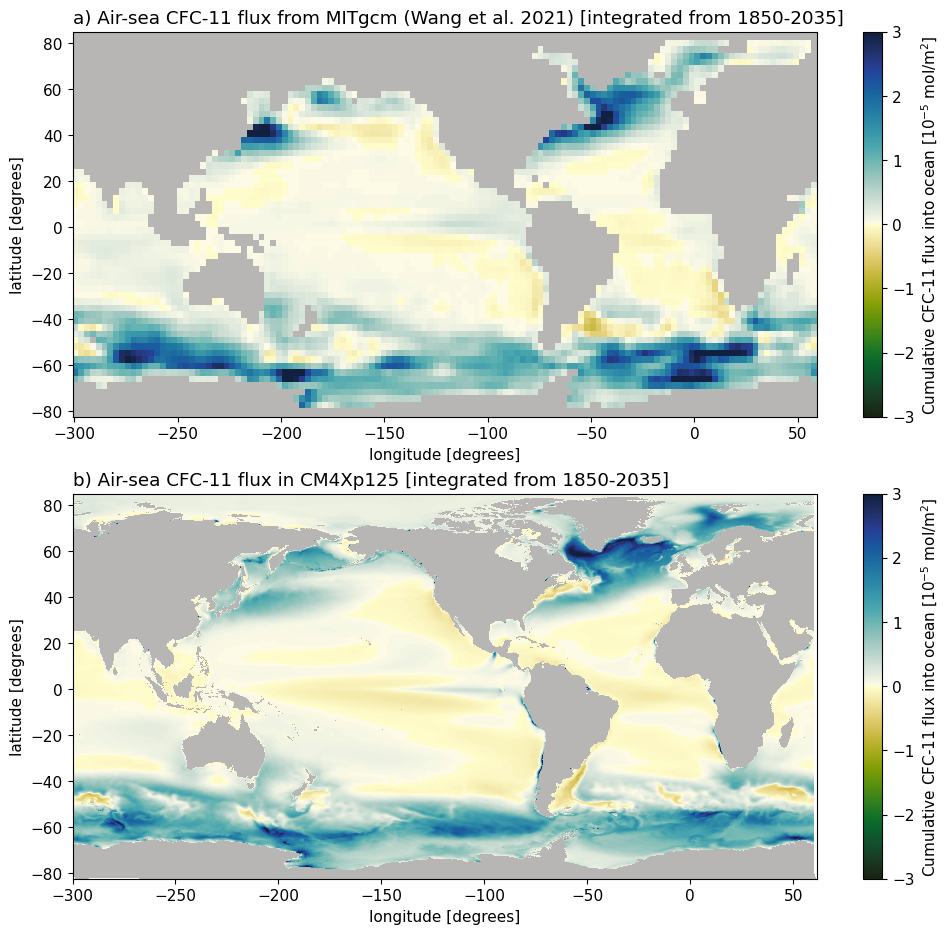

In [16]:
cmap = cmocean.cm.delta_r.copy()
cmap.set_bad((0.7, 0.7, 0.7))

fig, axes = plt.subplots(2,1,figsize=(12, 11))

ax = axes[0]
pc = ax.pcolormesh(
    ds.X,
    ds.Y,
    (ds.fgcfc11/grid.rA).sel(time=slice(1930, 2035)).sum("time")*sec_per_year_wang21*1e5, # mol/m2
    cmap=cmap,
    vmin=-3, vmax=3
)
ax.pcolormesh(
    ds.X,
    ds.Y,
    ds.fgcfc11.where(ds.fgcfc11==0).isel(time=-1) + 1,
    cmap=cmocean.cm.gray,
    vmin=0, vmax=1.3
)
plt.colorbar(pc, ax=ax, label=r"Cumulative CFC-11 flux into ocean [$10^{-5}$ mol/m$^{2}$]")
ax.set_xlabel("longitude [degrees]")
ax.set_ylabel("latitude [degrees]")
ax.set_ylim(-82.5, 85)
ax.set_title("a) Air-sea CFC-11 flux from MITgcm (Wang et al. 2021) [integrated from 1850-2035]", loc="left");

ax = axes[1]
pc = ax.pcolormesh(
    og.geolon_c,
    og.geolat_c,
    inv_dict['CM4Xp125']['fgcfc11_sink']*1e5,
    cmap=cmap,
    vmin=-3, vmax=3
)
ax.pcolormesh(
    og.geolon_c,
    og.geolat_c,
    og.deptho.fillna(0.).where(og.deptho.fillna(0.)==0) + 1,
    cmap=cmocean.cm.gray,
    vmin=0, vmax=1.3
)
plt.colorbar(pc, ax=ax, label=r"Cumulative CFC-11 flux into ocean [$10^{-5}$ mol/m$^{2}$]")
ax.set_xlabel("longitude [degrees]")
ax.set_ylabel("latitude [degrees]")
ax.set_ylim(-82.5, 85)
ax.set_title("b) Air-sea CFC-11 flux in CM4Xp125 [integrated from 1850-2035]", loc="left");
plt.savefig(f"../figures/SFig3_compare_air-sea_CFC11_flux_against_Wang2021_MITgcm.png", dpi=400, bbox_inches="tight")

In [17]:
df = pd.read_csv(f"{path}MITgcm_rcp_forcing_sensitivity_inventory_CFC11.csv")

<Axes: >

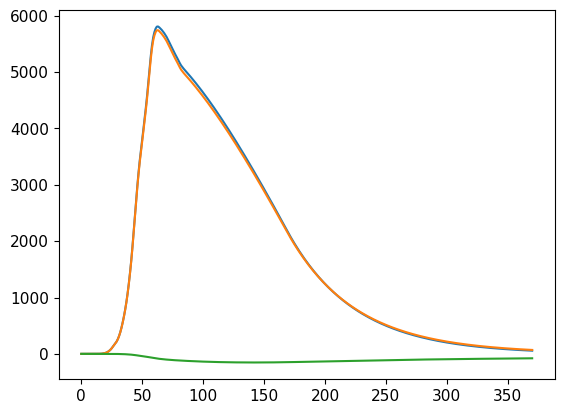

In [18]:
df['noOCN_atm'].plot()
df['hist_atm'].plot()
(-df['hist_ocn']).plot()

(0.0, 6000.0)

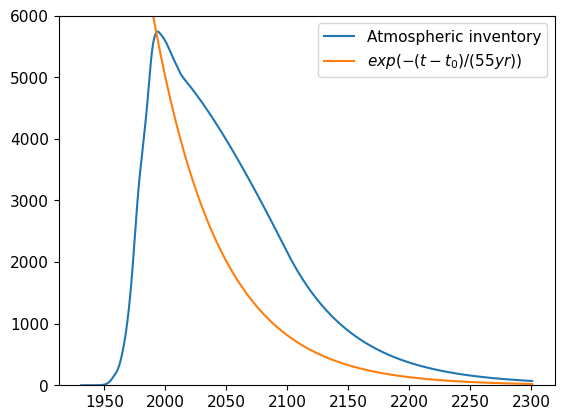

In [19]:
import numpy as np
plt.plot(df['Year'], df['hist_atm'], label="Atmospheric inventory")
τ = 55
plt.plot(
    df['Year'],
    (6000*np.exp(-(df['Year']-1990)/τ)),
    label=r"$exp(-(t-t_{0})/(55 yr))$"
)
plt.legend()
plt.ylim(0, 6000)